In [1]:
import ete3
from ete3 import Tree
import math
from ete3 import NCBITaxa
import pandas as pd
import pandas
import random
import numpy as np
from Bio import Phylo
from jw_utils import jw_draw_tree 
import plotly.graph_objects as go
import os
ncbi = NCBITaxa()

### Get bac120 tree and NCBI taxonomic IDs from GTDB  
release 202
https://data.gtdb.ecogenomic.org/releases/release202/  
download and unzip:
1) bac120_metadata_r202.tsv  
2) bac120_r202.tree  
bac120_metadata_r202.tsv is too large to include in github repository so will include processed smaller version 

In [2]:
#paths
path_to_tree =  '../bac120/bac120_r202.tree'  
path_to_metadata_tsv = '../bac120/bac120_metadata_r202.tsv'
path_to_csra_tsv = '../Data/csrs.tsv'
path_to_csra_clusters = '../Data/clusters.tsv'

In [4]:
def trim_bac120taxid_df(path_to_metadata_tsv, path_to_tree):
    """Return series with accessions not in tree removed."""
    
    bac120_taxid_df = pd.read_csv(path_to_metadata_tsv, sep='\t', usecols=['accession','ncbi_taxid'], low_memory=False)
    tree = Tree(path_to_tree, format=1, quoted_node_names=True)
    bac120_taxid_ser = bac120_taxid_df.set_index('accession')['ncbi_taxid']
    leaf_names = tree.get_leaf_names()
    return bac120_taxid_ser[leaf_names]

bac120_taxid_ser = trim_bac120taxid_df(path_to_metadata_tsv, path_to_tree)
path_to_small_data = '../bac120/bac120_taxids.csv'
bac120_taxid_ser.to_csv(path_to_small_data)
bac120_taxid_ser = pd.read_csv(path_to_small_data).set_index('accession')

In [6]:
bac120_taxid_ser = pd.read_csv(path_to_small_data).set_index('accession').squeeze()

In [7]:
def get_lower_rankID(taxID, rank, null_return='rank_not_available'):
    """Return lower rank NCBI taxoniomic ID from a given higher resolution ID"""
    
    if type(taxID)!= int:
        raise TypeError(f'taxID {taxID} is a {type(taxID)}, but needs to be of type "int"')  
    available_ranks = ['domain', 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    if rank not in available_ranks :
        raise ValueError(f'"{rank}" not in available ranks: {available_ranks}')
    lineage = ncbi.get_rank(ncbi.get_lineage(taxID))
    if rank not in lineage.values():
        return null_return
    else:
        lineage_d = {value:key for key, value in lineage.items()}
        return lineage_d[rank]

In [8]:
def read_csra_series(path_to_csra_tsv):
    csra_df = pd.read_csv(path_to_csra_tsv, sep='\t',usecols=['Entry','Taxonomic lineage IDs'], low_memory=False)
    return csra_df.set_index('Entry')['Taxonomic lineage IDs'].dropna().astype(int)


def change_taxID_rank(series, rank='phylum'):
    "change the TaxID to given rank"
    csras_diffrank = {}
    csra_d = series.to_dict()
    for seq_ID, taxID in csra_d.items():
        lower_taxID = get_lower_rankID(taxID,rank=rank)
        csras_diffrank[seq_ID]= lower_taxID
    return csras_diffrank
csras_phyla_d = change_taxID_rank(read_csra_series(path_to_csra_tsv), rank='phylum')

In [9]:
def get_rank_representative_dict(bac120_taxid_ser):
    """Return dict {Phyla_ID:seqID_representative}"""
    bac120_taxid = bac120_taxid_ser.to_dict()
    bac120_phylaID = {}
    for protID, taxID in bac120_taxid.items():
        bac120_phylaID[protID] = get_lower_rankID(taxID, 'phylum', null_return='rank_not_available')
    return {val:key for key,val in bac120_phylaID.items() if val !='rank_not_available'}

bac120_phylaID_reps_d = get_rank_representative_dict(bac120_taxid_ser)

/Users/jonwinkelman/miniconda3/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1705700 was translated into 33069
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/jonwinkelman/miniconda3/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2498859 was translated into 2498858
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/jonwinkelman/miniconda3/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1949084 was translated into 1808881
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/jonwinkelman/miniconda3/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1304902 was translated into 2731756
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/jonwinkelman/miniconda3/lib/python3.9/site-pack

In [10]:
def prune_bac120_tree(path_to_tree, list_of_leaf_IDs):
    tree = Tree(path_to_tree, format=1, quoted_node_names=True)
    tree.prune(list_of_leaf_IDs)
    return tree


list_of_leaf_IDs=list(bac120_phylaID_reps_d.values())
pruned_tree  = prune_bac120_tree(path_to_tree, list_of_leaf_IDs)
path_to_pruned_tree = './pruned_phyla_tree.nwk'
pruned_tree.write(outfile=path_to_pruned_tree, format=1)

In [11]:


def rename_pruned_treeleaves(path_to_pruned_tree,bac120_phylaID_reps_d):
    leafname_taxname_d = {}
    for taxID, leafname in bac120_phylaID_reps_d.items():
        name = list(ncbi.get_taxid_translator([taxID]).values())[0]
        leafname_taxname_d[leafname] = name
    tree = Phylo.read(path_to_pruned_tree, format='newick')
    for cl in tree.get_terminals():
        if leafname_taxname_d.get(cl.name):
            cl.name = leafname_taxname_d.get(cl.name)
    return tree

renamed_pruned_tree = rename_pruned_treeleaves(path_to_pruned_tree,bac120_phylaID_reps_d)

In [12]:
def get_dict_valcounts(csras_phyla_d, normalize=True):
    csra_phyla_df = pd.DataFrame.from_dict(csras_phyla_d, orient='index')
    csra_phyla_df.columns = ['TaxID_phylum']
    return csra_phyla_df['TaxID_phylum'].value_counts(normalize=normalize).to_dict()



def rename_dict_valcounts(csra_valcounts):
    renamed_valcounts={}
    for taxID, counts in csra_valcounts.items():
        if taxID != 'rank_not_available':
            name = list(ncbi.get_taxid_translator([taxID]).values())[0]
            renamed_valcounts[name]=counts
    return renamed_valcounts
            
            
        
def make_data_dict(renamed_valcounts, renamed_pruned_tree, rank='Phyla'): 
    """return nested input dict for figure making"""
    data_dict = {}      
    for cl in renamed_pruned_tree.get_terminals():
        if renamed_valcounts.get(cl.name):
            data_dict[cl.name] = renamed_valcounts.get(cl.name)
        else:
            data_dict[cl.name] = 0
    return {rank:data_dict}

renamed_valcounts = rename_dict_valcounts(get_dict_valcounts(csras_phyla_d)) 
data_dict = make_data_dict(renamed_valcounts, renamed_pruned_tree, rank='Phyla')

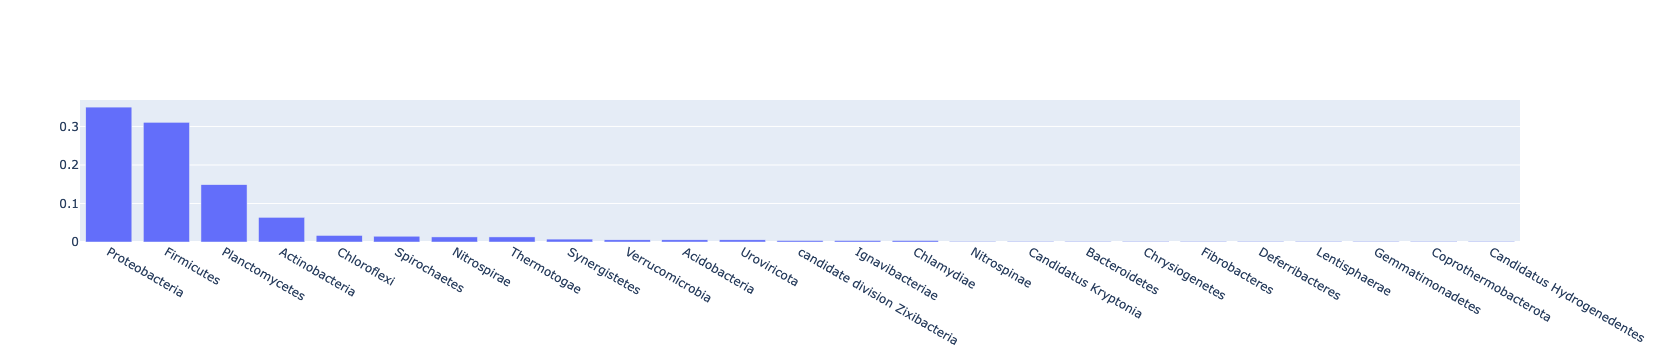

In [14]:
trace = go.Bar(x=list(renamed_valcounts.keys()), y = list(renamed_valcounts.values()) )
go.Figure(trace)

# bac120_taxid_valcounts = bac120_taxid_ser.value_counts()
# bac120_name_valcounts = {}
# for taxID in bac120_taxid_valcounts.index:
#     name = ncbi.get_taxid_translator([taxID])[taxID]
#     bac120_name_valcounts[name] = bac120_taxid_valcounts[taxID]
    

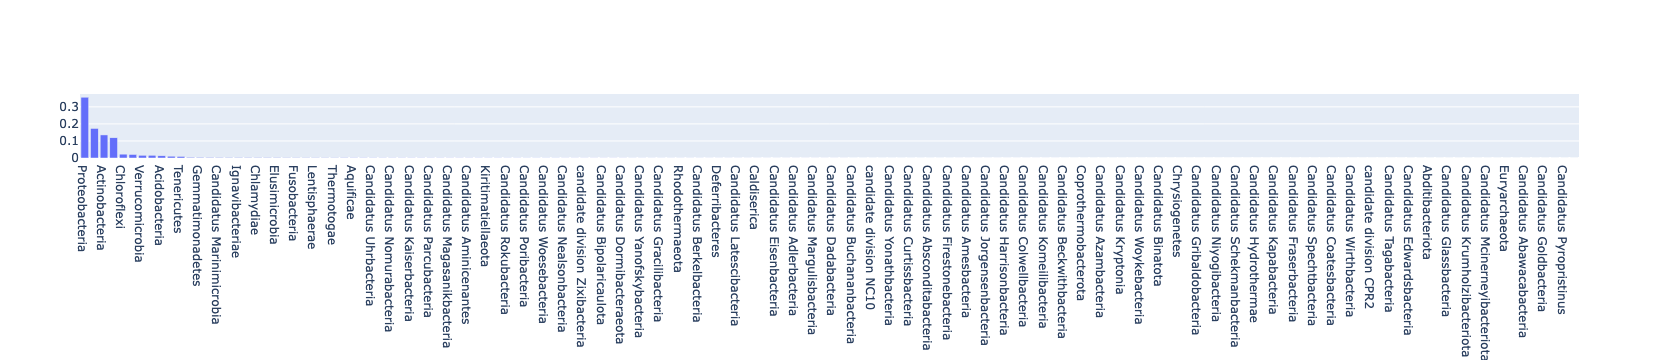

In [16]:
bac120_phyl_d = change_taxID_rank(bac120_taxid_ser, rank='phylum')
renamed_bac120_valcounts = rename_dict_valcounts(get_dict_valcounts(bac120_phyl_d)) 
bac120_trace = go.Bar(x=list(renamed_bac120_valcounts.keys()), y = list(renamed_bac120_valcounts.values()))
go.Figure(data=[bac120_trace])

In [17]:
df_bac_distributions = pd.DataFrame.from_dict(renamed_bac120_valcounts, orient='index')
df_csra_distributions = pd.DataFrame.from_dict(renamed_valcounts, orient='index')

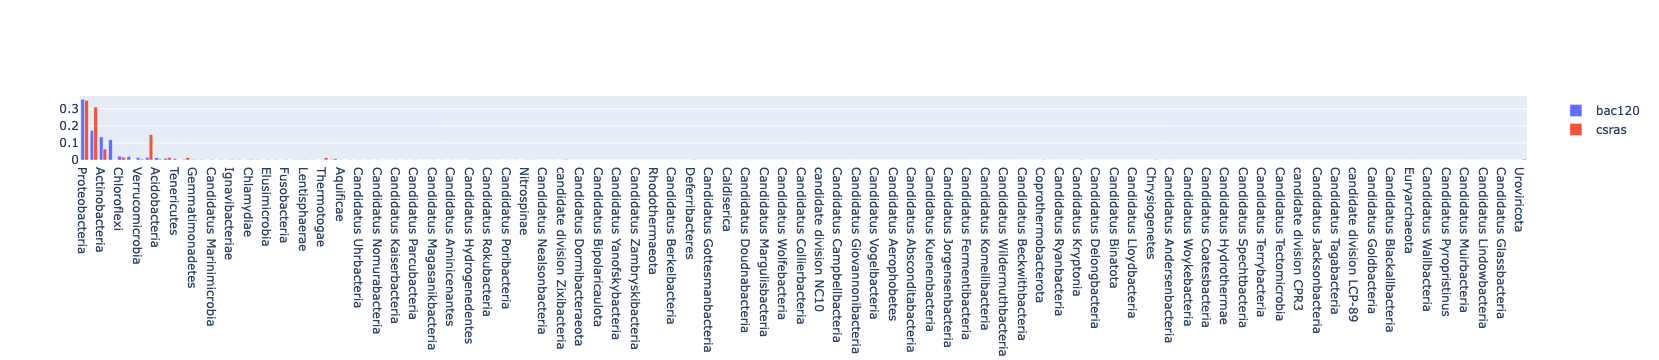

In [18]:
df_distributions = pd.merge(df_bac_distributions, df_csra_distributions, left_index=True, 
                            right_index=True, how='outer').fillna(0)
df_distributions.columns = ['bac120', 'csras']
df_distributions = df_distributions.sort_values('bac120', ascending=False)
bac120_trace = go.Bar(x= df_distributions.index, y= df_distributions['bac120'], name='bac120')
csra_trace = go.Bar(x= df_distributions.index, y= df_distributions['csras'], name = 'csras')
fig = go.Figure(data = [bac120_trace, csra_trace])
fig.write_html('./bac120_csra_phyla_dist.html')
fig

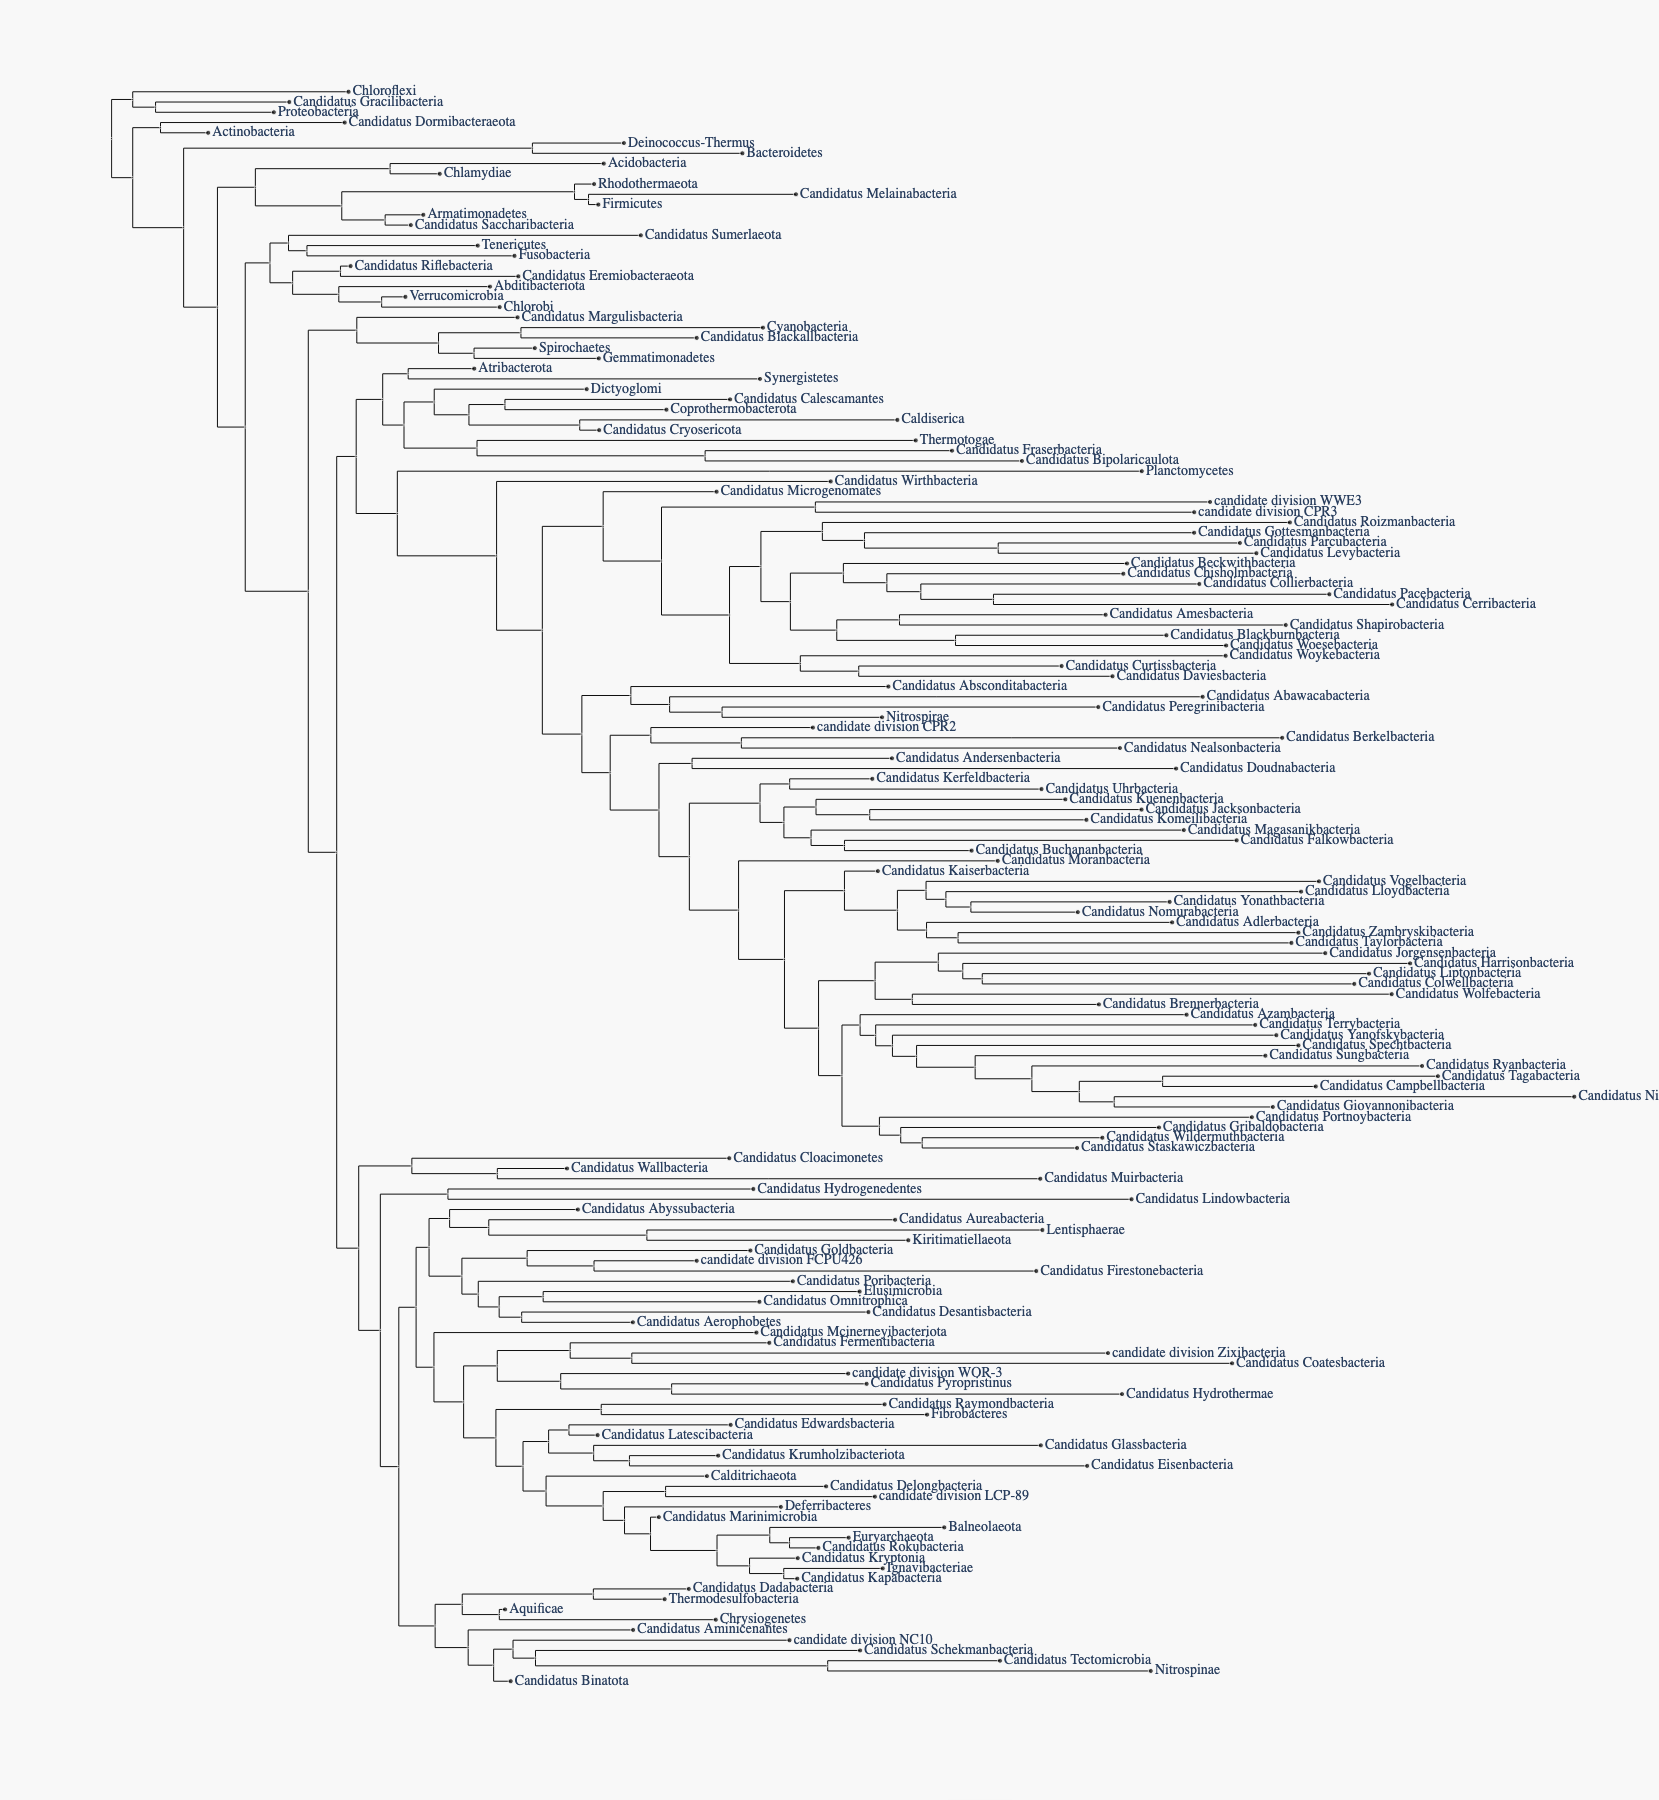

In [19]:
fig = jw_draw_tree.create_tree(renamed_pruned_tree,data_dict, label_mode='markers+text',
                              t_node_size=5,height=1800)
go.Figure(fig)


1.7713400000000001 1.7613400000000001
1.7913400000000002 1.7613400000000001
1.8113400000000002 1.7613400000000001
1.91134 1.7613400000000001
3.3513400000000004 1.7613400000000001
5.07134 1.7613400000000001
5.49134 1.7613400000000001


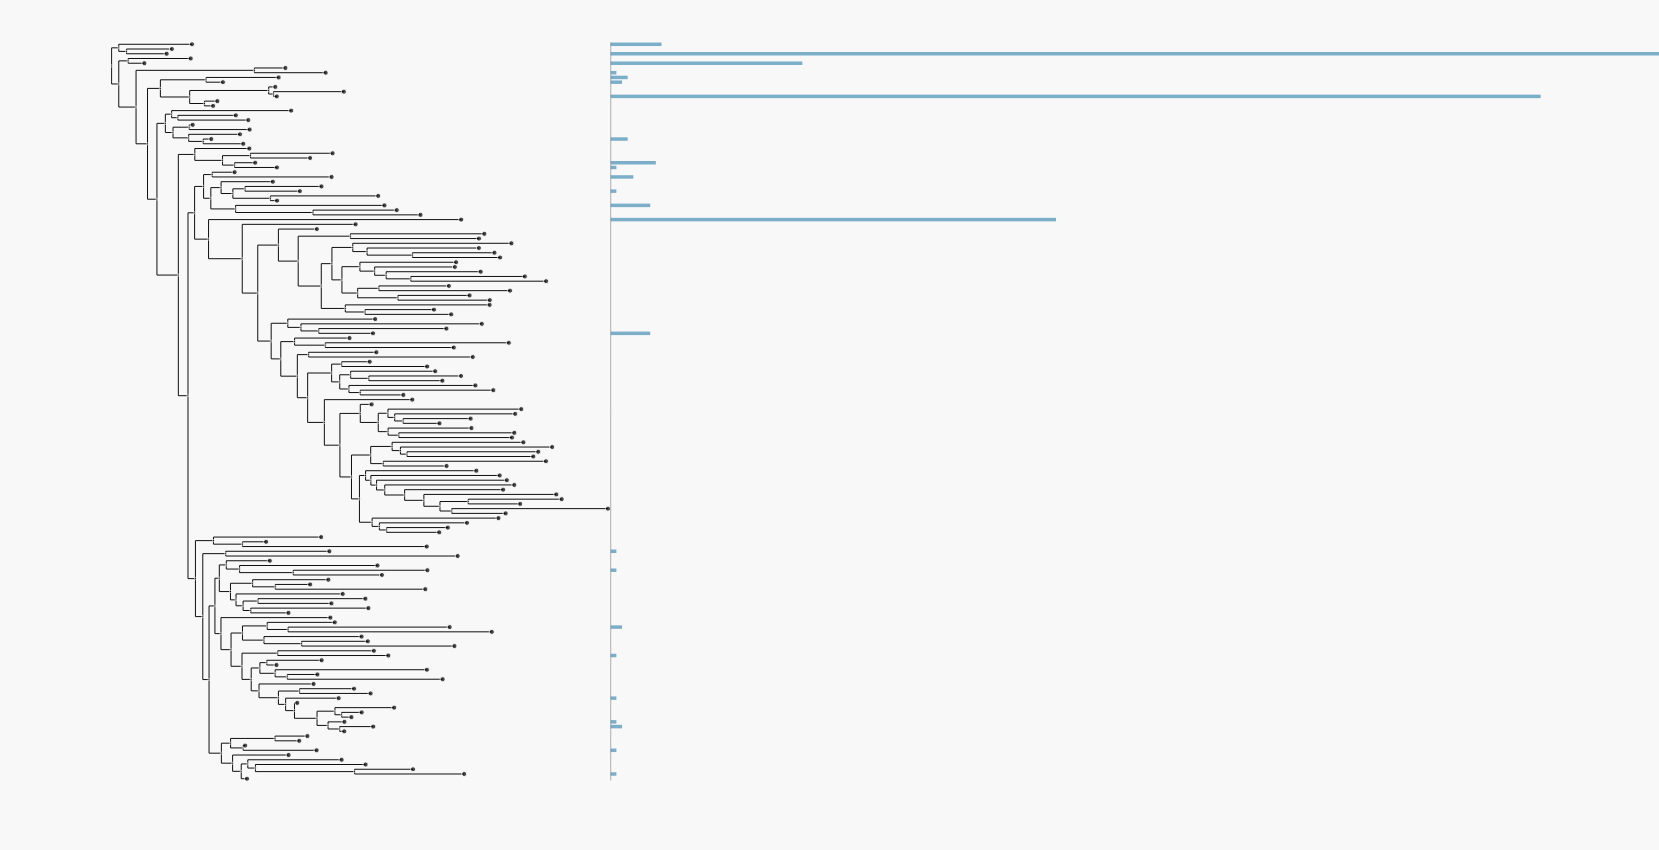

In [20]:
renamed_valcnts_abs = rename_dict_valcounts(get_dict_valcounts(csras_phyla_d, normalize=False)) 
data_dict = make_data_dict(renamed_valcnts_abs, renamed_pruned_tree, rank='Phyla')
data_dict
fig = jw_draw_tree.create_tree_w_bargraphs(renamed_pruned_tree, data_dict, label_mode='markers', 
                                           t_node_size= 5)

fig.write_html('./csra_mapped_bac120phyla.html')
go.Figure(fig)